In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import gzip

---
## floodzones
source: [Geonorge](https://kartkatalog.geonorge.no/metadata/flomsoner/e95008fc-0945-4d66-8bc9-e50ab3f50401)

Projection according to website: 
EUREF89 UTM sone 33, 2d

In [6]:
# Path to the GML file
file_path = 'data/Samfunnssikkerhet_03_Oslo_25833_Flomsoner_GML.gml'

# Reading the GML file into a GeoDataFrame
flood_gdf = gpd.read_file(file_path)

# Set the CRS to EPSG:25833 (which is the code for euref89 UTM)
flood_gdf.set_crs('epsg:25833', inplace=True)

# Convert the CRS to EPSG:4326 for mapping with Folium
flood_gdf = flood_gdf.to_crs(epsg=4326)

# Display the first few rows of the GeoDataFrame
# print(flood_gdf.head())

In [8]:
flood_gdf.flomsoneNavn.unique()

array(['Ellingsrudelva', 'Sørkedalselva'], dtype=object)

In [10]:
map = folium.Map(location=[59.9139, 10.7522], zoom_start=10)  # Coordinates for Oslo


# Adding polygons to the map
for _, row in flood_gdf.iterrows():
    # Simplifying the geometry can help performance, adjust the tolerance as needed
    # simplified_geom = row.geometry.simplify(tolerance=0.00001, preserve_topology=True)
    geo_json = folium.GeoJson(
        row.geometry,
        name='geojson',
        popup=folium.Popup(f"Feature: {row['flomsoneNavn']}")
    )
    geo_json.add_to(map)

map

---
## listings
source: [InsideAirbnb](https://insideairbnb.com/get-the-data/)

In [13]:
listings = pd.read_csv('data/listings.csv')

In [15]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10099 entries, 0 to 10098
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10099 non-null  int64  
 1   listing_url                                   10099 non-null  object 
 2   scrape_id                                     10099 non-null  int64  
 3   last_scraped                                  10099 non-null  object 
 4   source                                        10099 non-null  object 
 5   name                                          10099 non-null  object 
 6   description                                   9735 non-null   object 
 7   neighborhood_overview                         3738 non-null   object 
 8   picture_url                                   10099 non-null  object 
 9   host_id                                       10099 non-null 

In [33]:
# first, create a new column in the DataFrame that will hold the geometry
listings['geometry'] = [Point(xy) for xy in zip(listings['longitude'], listings['latitude'])]

# Now, convert the DataFrame to a GeoDataFrame
listings_gdf = gpd.GeoDataFrame(listings, geometry='geometry')

# Optionally, set the coordinate reference system (CRS) if known, e.g., WGS84 (lat-long)
listings_gdf.set_crs("epsg:4326", inplace=True)

# Display the GeoDataFrame
print(listings_gdf.head())

       id                          listing_url       scrape_id last_scraped  \
0   42932   https://www.airbnb.com/rooms/42932  20240629155744   2024-06-29   
1   71725   https://www.airbnb.com/rooms/71725  20240629155744   2024-06-29   
2   85902   https://www.airbnb.com/rooms/85902  20240629155744   2024-06-29   
3  123041  https://www.airbnb.com/rooms/123041  20240629155744   2024-06-29   
4  149776  https://www.airbnb.com/rooms/149776  20240629155744   2024-06-30   

        source                                              name  \
0  city scrape               Charming apartment, Oslo Center, Ro   
1  city scrape                Central big room - ap with balcony   
2  city scrape                 Stylish design Apt, super central   
3  city scrape  Cozy room in design apartment, central east side   
4  city scrape                  Bird's nest in the heart of Oslo   

                                         description  \
0                                                NaN   
1  A

In [35]:
listings_gdf_short = listings_gdf[1:1000] # subset first 1k observations to make it faster

In [37]:
import matplotlib.colors
from matplotlib.colors import Normalize

In [39]:
# Create a colormap
cmap = plt.cm.get_cmap('viridis')  # Or any other colormap

# Function to normalize data and convert to hex
def normalize_color(value, vmin, vmax):
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgb = cmap(norm(value))[:3]  # get RGB from RGBA
    hex_color = matplotlib.colors.rgb2hex(rgb)
    return hex_color

# Create the base map
map = folium.Map(location=[listings_gdf_short['latitude'].mean(), listings_gdf_short['longitude'].mean()], zoom_start=10, tiles='cartodbpositron')

# Adding points to the map
for idx, row in listings_gdf_short.iterrows():
    if not pd.isna(row['review_scores_location']):
        color = normalize_color(row['review_scores_location'], listings_gdf_short['review_scores_location'].min(), listings_gdf['review_scores_location'].max())
        folium.CircleMarker(
            location=(row['latitude'], row['longitude']),
            radius=5,  # Adjust the size as needed
            popup=f"Score: {row['review_scores_location']}",
            color=color,
            fill=True
        ).add_to(map)

# Display the map
map

---
## listings in floodzone

In [42]:
print(flood_gdf.columns)
print(listings_gdf.columns)

Index(['gml_id', 'flomsoneID', 'lokalId', 'navnerom', 'versjonId',
       'datauttaksdato', 'opphav', 'statusDato', 'statusKartlegging',
       'vassdragsnummer', 'prosjektURL', 'flomberegningsURL', 'rapportURL',
       'høydeReferanse', 'flomsoneOmråde', 'orgKoordSys', 'flomsoneNavn',
       'kartlagteFlommer', 'nedbørfelt', 'rapportNr', 'geometry'],
      dtype='object')
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'lati

In [44]:
# Check the CRS of both GeoDataFrames
print(f"Listings CRS: {listings_gdf.crs}")
print(f"Flood CRS: {flood_gdf.crs}")

# If the CRSs are different, align them (assuming flood_gdf is in the desired CRS)
if listings_gdf.crs != flood_gdf.crs:
    listings_gdf = listings_gdf.to_crs(flood_gdf.crs)

Listings CRS: epsg:4326
Flood CRS: EPSG:4326


In [46]:
# Perform the spatial join
within_flood_zone = gpd.sjoin(listings_gdf, flood_gdf, how="inner", predicate='within')

# within_flood_zone will contain all columns from listings_gdf plus the attributes from flood_gdf for matching polygons
within_flood_zone

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,prosjektURL,flomberegningsURL,rapportURL,høydeReferanse,flomsoneOmråde,orgKoordSys,flomsoneNavn,kartlagteFlommer,nedbørfelt,rapportNr
2391,562130130427110670,https://www.airbnb.com/rooms/562130130427110670,20240629155744,2024-06-29,city scrape,Stor kjellerleilighet i Sørkedalen,Large basement apartment right next to Oslo’s ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,14125567,...,https://www.nve.no/flaum-og-skred/kartlegging/...,http://publikasjoner.nve.no/dokument/2008/doku...,http://publikasjoner.nve.no/flomsonekart/2010/...,NaN,Sørkedalselva,UTM32,Sørkedalselva,"20,200",LYSAKERELVA,2010_06


---
## calendar
source: [InsideAirbnb](https://insideairbnb.com/get-the-data/)

In [92]:
file_path = 'data/calendar.csv.gz'
with gzip.open(file_path, 'rt') as file:  # 'rt' mode for reading text
    # Creating a DataFrame from the CSV file
    calendar = pd.read_csv(file)

/var/folders/0k/103494dx1c5gpkpbrpkwnk180000gn/T/ipykernel_53581/3531901982.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  calendar = pd.read_csv(file)


In [93]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3078404,2024-06-29,f,"$1,500.00",NaN,7.0,20.0
1,3078404,2024-06-30,f,"$1,500.00",NaN,7.0,20.0
2,3078404,2024-07-01,f,"$1,500.00",NaN,7.0,20.0
3,3078404,2024-07-02,f,"$1,500.00",NaN,7.0,20.0
4,3078404,2024-07-03,f,"$1,500.00",NaN,7.0,20.0


In [94]:
# Convert 'date' column to datetime
calendar['date'] = pd.to_datetime(calendar['date'])

# Remove any currency symbols and convert 'price' to float
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

# Remove outliers: prices above $5000
calendar = calendar[calendar['price'] <= 2000]

# Check the conversion
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3019498 entries, 0 to 3686135
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           float64       
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 184.3+ MB


In [97]:
calendar.price.max()
# help(pd.Series)

2000.0

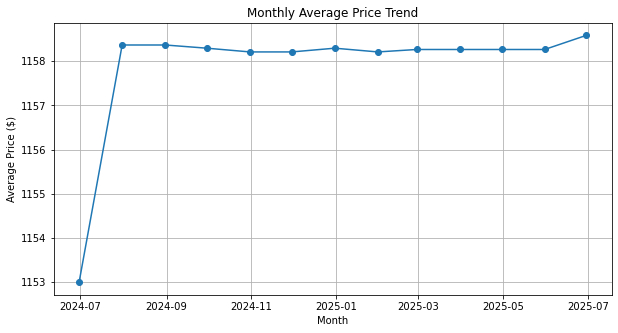

In [100]:
# Resample or group by month or week
calendar.set_index('date', inplace=True)
monthly_avg = calendar['price'].resample('M').mean()

# Plotting the monthly average price
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg.index, monthly_avg, marker='o', linestyle='-')
plt.title('Monthly Average Price Trend')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.grid(True)
plt.show()


---
## neighbourhoods
source: [InsideAirbnb](https://insideairbnb.com/get-the-data/)

In [104]:
# Path to the GeoJSON file
file_path = 'data/neighbourhoods.geojson'

# Read the GeoJSON file into a GeoDataFrame
neighbourhoods_geo = gpd.read_file(file_path)

In [106]:
neighbourhoods_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighbourhood        17 non-null     object  
 1   neighbourhood_group  0 non-null      float64 
 2   geometry             17 non-null     geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 536.0+ bytes


---
## reviews
source: [InsideAirbnb](https://insideairbnb.com/get-the-data/)

In [108]:
reviews = pd.read_csv('data/reviews.csv')

In [110]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167633 entries, 0 to 167632
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     167633 non-null  int64 
 1   id             167633 non-null  int64 
 2   date           167633 non-null  object
 3   reviewer_id    167633 non-null  int64 
 4   reviewer_name  167633 non-null  object
 5   comments       167620 non-null  object
dtypes: int64(3), object(3)
memory usage: 7.7+ MB


In [118]:
# List of keywords to search for
keywords = ['avalanche']#, 'snøskred', 'rockfall', 'heavy rain']

# Creating a regex pattern to match any of the keywords
pattern = '|'.join(keywords)

# Filtering comments that contain any of the keywords
filtered_comments = reviews[reviews['comments'].str.contains(pattern, case=False, na=False)]

In [120]:
# Setting options to avoid truncating text
pd.set_option('display.max_colwidth', None)  # None means no truncation; show all the text
pd.set_option('display.max_rows', None)  # Adjust or remove according to the size of your output

# Print only the 'comments' column of the filtered DataFrame
print(filtered_comments['comments'])

7371    We were in a bind when we contacted John and Hilde 24 hours before arriving in Oslo to request the room. An avalanche on the train tracks to Bergen forced us to change our plans and go back to Oslo at the last minute. They responded immediately to our plea for a place to stay and were extremely responsive until we arrived, giving us frequent updates on how to find their place, how to get in, where to pick up the keys, etc. They were so incredibly helpful in a chaotic and stressful travel time for us. We were so relieved to get to their place and find an extremely comfy bed, hot shower, welcome book with tips on things to see on our extra day in Oslo, and so grateful to have a flexible check-in and check-out time that accommodated our flight home perfectly. The room also has a nice view of the park and there are grocery stores nearby and it is within walking distance of the center of town (about 7 minutes from the central train station and easy to locate).\r<br/>Unfortunately we